<a href="https://colab.research.google.com/github/https-deeplearning-ai/tensorflow-1-public/blob/main/C4/W4/ungraded_labs/C4_W4_Lab_3_Sunspots_CNN_RNN_DNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Ungraded Lab: Predicting Sunspots with Neural Networks

At this point in the course, you should be able to explore different network architectures for forecasting. In the previous weeks, you've used DNNs, RNNs, and CNNs to build these different models. In the final practice lab for this course, you'll try one more configuration and that is a combination of all these types of networks: the data windows will pass through a convolution, followed by stacked LSTMs, followed by stacked dense layers. See if this improves results or you can just opt for simpler models.

## Imports

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import csv
import pandas as pd

## Utilities

In [ ]:
def plot_series(x, y, format="-", start=0, end=None,
                title=None, xlabel=None, ylabel=None, legend=None ):
    """
    Visualizes time series data

    Args:
      x (array of int) - contains values for the x-axis
      y (array of int or tuple of arrays) - contains the values for the y-axis
      format (string) - line style when plotting the graph
      start (int) - first time step to plot
      end (int) - last time step to plot
      title (string) - title of the plot
      xlabel (string) - label for the x-axis
      ylabel (string) - label for the y-axis
      legend (list of strings) - legend for the plot
    """

    # Setup dimensions of the graph figure
    plt.figure(figsize=(10, 6))
    ax = plt.axes()
    ax.set_facecolor('None')
    # Check if there are more than two series to plot
    if type(y) is tuple:

      # Loop over the y elements
      for y_curr in y:

        # Plot the x and current y values
        plt.plot(x[start:end], y_curr[start:end], format)

    else:
      # Plot the x and y values
      plt.plot(x[start:end], y[start:end], format)

    # Label the x-axis
    plt.xlabel(xlabel)
    # Label the y-axis
    plt.ylabel(ylabel)

    # Set the legend
    if legend:
      plt.legend(legend)

    # Set the title
    plt.title(title)

    # Overlay a grid on the graph
    plt.grid(True)

    # Draw the graph on screen
    plt.show()

## Download and Preview the Dataset

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

%cd /content/drive/MyDrive/Thesis/Datasets

Mounted at /content/drive
/content/drive/MyDrive/Thesis/Datasets


In [ ]:
df = pd.read_csv("weekly_sales_data.csv")
# Convert the 'Date' column to datetime type
#df['Date'] = pd.to_datetime(df['Unnamed: 0'])
#df.drop('Unnamed: 0', axis=1, inplace=True)
# Set the 'Date' column as the index
df.set_index('Date', inplace=True)

In [ ]:
df.head()

,sales
Date,
2014-01-12,2.71
2014-01-19,1.25
2014-01-26,1.66
2014-02-02,0.62
2014-02-09,0.01


In [ ]:
'''# Download the Dataset
!wget https://storage.googleapis.com/tensorflow-1-public/course4/Sunspots.csv
'''

'# Download the Dataset\n!wget https://storage.googleapis.com/tensorflow-1-public/course4/Sunspots.csv\n'

<class 'numpy.ndarray'>


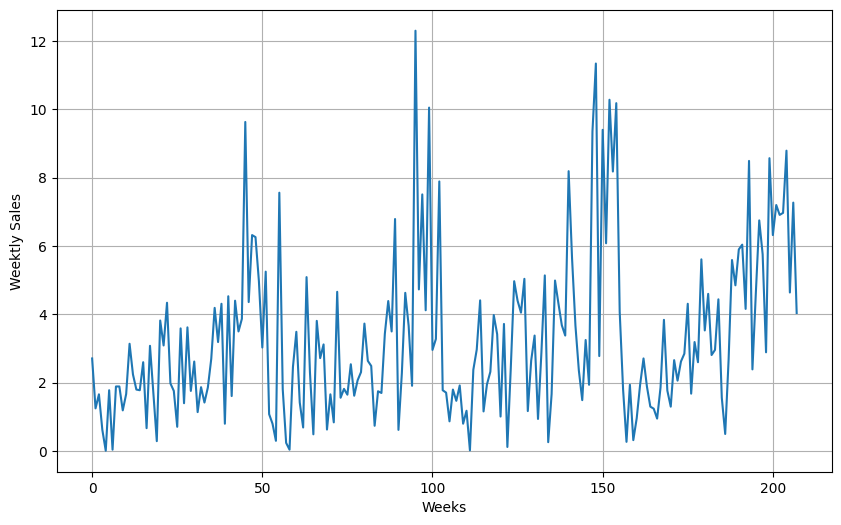

In [ ]:
# Initialize lists
'''
time_step = []
sales = []
# Open CSV file
with open('./Sunspots.csv') as csvfile:

  # Initialize reader
  reader = csv.reader(csvfile, delimiter=',')

  # Skip the first line
  next(reader)

  # Append row and sunspot number to lists
  for row in reader:
    time_step.append(int(row[0]))
    sunspots.append(float(row[2]))

# Convert lists to numpy arrays
time = np.array(time_step)
series = np.array(sales)
'''
# Parameters
time = np.arange(len(df.index), dtype="float32")
date = df.index
series = df['sales'].values
print(type(series))

# Plot the results
#plot_series(date, series)

# Preview the data
plot_series(time, series, xlabel='Weeks', ylabel='Weektly Sales')

## Split the Dataset

In [ ]:
'''# Define the split time
split_time = 3000

# Get the train set
time_train = time[:split_time]
x_train = series[:split_time]

# Get the validation set
time_valid = time[split_time:]
x_valid = series[split_time:]
'''
import math
# Define the split time
split_time = math.floor(len(series) * 3 / 4)

# Get the train set
time_train = time[:split_time]
x_train = series[:split_time]

# Get the validation set
time_valid = time[split_time:]
x_valid = series[split_time:]

print(len(time_train))
print(len(time_valid))

156
52


## Prepare Features and Labels

In [ ]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    """Generates dataset windows

    Args:
      series (array of float) - contains the values of the time series
      window_size (int) - the number of time steps to include in the feature
      batch_size (int) - the batch size
      shuffle_buffer(int) - buffer size to use for the shuffle method

    Returns:
      dataset (TF Dataset) - TF Dataset containing time windows
    """

    # Generate a TF Dataset from the series values
    dataset = tf.data.Dataset.from_tensor_slices(series)

    # Window the data but only take those with the specified size
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)

    # Flatten the windows by putting its elements in a single batch
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))

    # Create tuples with features and labels
    dataset = dataset.map(lambda window: (window[:-1], window[-1]))

    # Shuffle the windows
    dataset = dataset.shuffle(shuffle_buffer)

    # Create batches of windows
    dataset = dataset.batch(batch_size).prefetch(1)

    return dataset

As mentioned in the lectures, if your results don't good, you can try tweaking the parameters here and see if the model will learn better.

In [ ]:
# Parameters
window_size = 52
batch_size = 16

shuffle_buffer_size = 1000

# Generate the dataset windows
train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

## Build the Model

You've seen these layers before and here is how it's looks like when combined.

In [ ]:
'''# Build the Model
model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=64, kernel_size=5,
                      strides=1,
                      activation="relu",
                      padding='causal',
                      input_shape=[window_size, 1]),
  tf.keras.layers.LSTM(52, return_sequences=True),
  tf.keras.layers.LSTM(52),
  tf.keras.layers.Dense(52, activation="relu"),
  tf.keras.layers.Dense(26, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])

 # Print the model summary
model.summary()
'''

'# Build the Model\nmodel = tf.keras.models.Sequential([\n  tf.keras.layers.Conv1D(filters=64, kernel_size=5,\n                      strides=1,\n                      activation="relu",\n                      padding=\'causal\',\n                      input_shape=[window_size, 1]),\n  tf.keras.layers.LSTM(52, return_sequences=True),\n  tf.keras.layers.LSTM(52),\n  tf.keras.layers.Dense(52, activation="relu"),\n  tf.keras.layers.Dense(26, activation="relu"),\n  tf.keras.layers.Dense(1),\n  tf.keras.layers.Lambda(lambda x: x * 400)\n])\n\n # Print the model summary\nmodel.summary()\n'

In [ ]:
l2_regularization = 0.03
dropout_rate = 0.115

# Build the Model
model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=16, kernel_size=3,
                      strides=1,
                      activation="relu",
                      padding='causal',
                      input_shape=[None, 1]),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(52, return_sequences=True, dropout=dropout_rate)),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(52, kernel_regularizer=tf.keras.regularizers.l2(l2_regularization))),
#  tf.keras.layers.Dense(26, activation="relu"),
#  tf.keras.layers.Dense(13, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 100)
])

 # Print the model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, None, 16)          64        
                                                                 
 bidirectional (Bidirectiona  (None, None, 104)        28704     
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 104)              65312     
 nal)                                                            
                                                                 
 dense (Dense)               (None, 1)                 105       
                                                                 
 lambda (Lambda)             (None, 1)                 0         
                                                                 
Total params: 94,185
Trainable params: 94,185
Non-traina

In [ ]:
'''# Define the L2 regularization parameter
l1_regularization = 0.005
l2_regularization = 0.005
# Define the dropout rate for LSTM layers
dropout_rate = 0.05

# Build the Model with regularization
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv1D(filters=64, kernel_size=5,
                           strides=1,
                           activation="relu",
                           padding='causal',
                           input_shape=[window_size, 1]),
    tf.keras.layers.LSTM(52, return_sequences=True, kernel_regularizer=tf.keras.regularizers.l2(l2_regularization)),
    tf.keras.layers.LSTM(52,  dropout=dropout_rate),
    tf.keras.layers.Dense(52, activation="relu", kernel_regularizer=tf.keras.regularizers.l2(l1_regularization)),
    tf.keras.layers.Dense(26, activation="relu", kernel_regularizer=tf.keras.regularizers.l2(l2_regularization)),
    tf.keras.layers.Dense(1),
    tf.keras.layers.Lambda(lambda x: x * 100.0) # range of number
])

# Print the model summary
model.summary()'''

'# Define the L2 regularization parameter\nl1_regularization = 0.005\nl2_regularization = 0.005\n# Define the dropout rate for LSTM layers\ndropout_rate = 0.05\n\n# Build the Model with regularization\nmodel = tf.keras.models.Sequential([\n    tf.keras.layers.Conv1D(filters=64, kernel_size=5,\n                           strides=1,\n                           activation="relu",\n                           padding=\'causal\',\n                           input_shape=[window_size, 1]),\n    tf.keras.layers.LSTM(52, return_sequences=True, kernel_regularizer=tf.keras.regularizers.l2(l2_regularization)),\n    tf.keras.layers.LSTM(52,  dropout=dropout_rate),\n    tf.keras.layers.Dense(52, activation="relu", kernel_regularizer=tf.keras.regularizers.l2(l1_regularization)),\n    tf.keras.layers.Dense(26, activation="relu", kernel_regularizer=tf.keras.regularizers.l2(l2_regularization)),\n    tf.keras.layers.Dense(1),\n    tf.keras.layers.Lambda(lambda x: x * 100.0) # range of number\n])\n\n# Prin

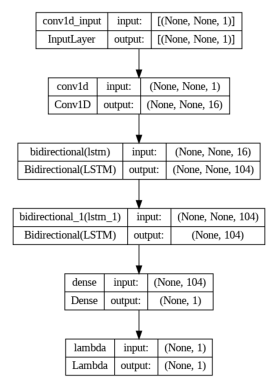

In [ ]:
from io import BytesIO
# Create a buffer to save the model summary image
buffer = BytesIO()

# Plot the model summary and save it to a file
tf.keras.utils.plot_model(model, to_file="model_summary.png", show_shapes=True, show_layer_names=True)

# Display the saved image
img = plt.imread("model_summary.png")
plt.imshow(img)
plt.axis('off')
plt.show()

## Tune the Learning Rate

As usual, you will want to pick an optimal learning rate.

In [ ]:
# Get initial weights
init_weights = model.get_weights()

In [ ]:
# Set the learning rate scheduler
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))

# Initialize the optimizer
optimizer = tf.keras.optimizers.Adam()

# Set the training parameters
model.compile(loss=tf.keras.losses.Huber(), optimizer=optimizer)

# Train the model
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

Epoch 1/100
7/7 [==============================] - 11s 141ms/step - loss: 12.5977 - lr: 1.0000e-08
Epoch 2/100
7/7 [==============================] - 1s 84ms/step - loss: 12.4971 - lr: 1.1220e-08
Epoch 3/100
7/7 [==============================] - 1s 81ms/step - loss: 12.7783 - lr: 1.2589e-08
Epoch 4/100
7/7 [==============================] - 1s 81ms/step - loss: 13.1466 - lr: 1.4125e-08
Epoch 5/100
7/7 [==============================] - 1s 84ms/step - loss: 12.7796 - lr: 1.5849e-08
Epoch 6/100
7/7 [==============================] - 1s 86ms/step - loss: 12.4468 - lr: 1.7783e-08
Epoch 7/100
7/7 [==============================] - 1s 84ms/step - loss: 12.7999 - lr: 1.9953e-08
Epoch 8/100
7/7 [==============================] - 1s 82ms/step - loss: 12.5184 - lr: 2.2387e-08
Epoch 9/100
7/7 [==============================] - 1s 85ms/step - loss: 12.8236 - lr: 2.5119e-08
Epoch 10/100
7/7 [==============================] - 1s 84ms/step - loss: 12.4378 - lr: 2.8184e-08
Epoch 11/100
7/7 [=========

(1e-08, 0.001, 0.0, 30.0)

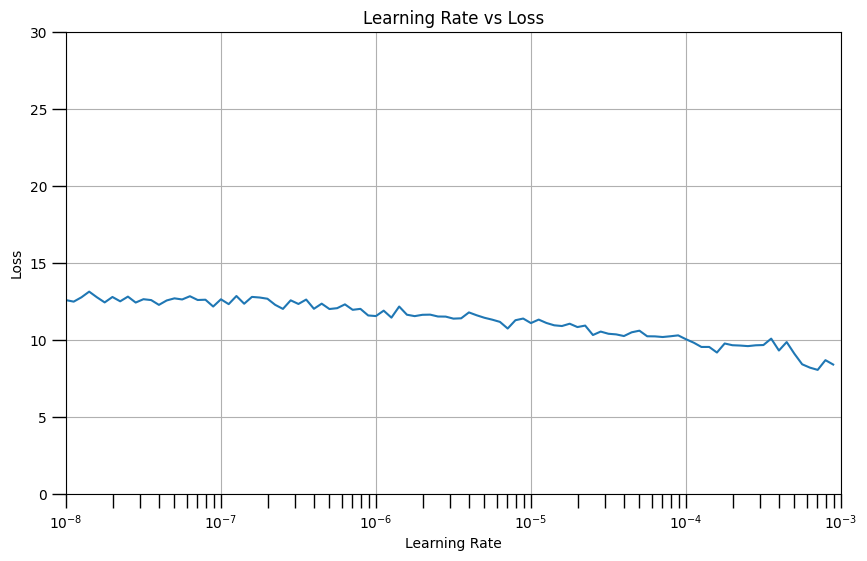

In [ ]:
# Define the learning rate array
lrs = 1e-8 * (10 ** (np.arange(100) / 20))

# Set the figure size
plt.figure(figsize=(10, 6))

# Set the grid
plt.grid(True)

# Plot the loss in log scale
plt.semilogx(lrs, history.history["loss"])

# Increase the tickmarks size
plt.tick_params('both', length=10, width=1, which='both')
plt.xlabel("Learning Rate")
plt.ylabel("Loss")
plt.title("Learning Rate vs Loss")
# Set the plot boundaries
plt.axis([1e-8, 1e-3, 0, 30])

## Train the Model

Now you can proceed to reset and train the model. It is set for 100 epochs in the cell below but feel free to increase it if you want. Laurence got his results in the lectures after 500.

In [ ]:
# Reset states generated by Keras
tf.keras.backend.clear_session()

# Reset the weights
model.set_weights(init_weights)

In [ ]:
# Set the learning rate
learning_rate = 1e-4

# Set the optimizer
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

# Set the training parameters
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

In [ ]:
# Train the model
history = model.fit(train_set,epochs=500)

Epoch 1/500
7/7 [==============================] - 11s 19ms/step - loss: 12.0755 - mae: 4.3105
Epoch 2/500
7/7 [==============================] - 0s 15ms/step - loss: 11.2261 - mae: 3.4654
Epoch 3/500
7/7 [==============================] - 0s 14ms/step - loss: 11.2034 - mae: 3.4641
Epoch 4/500
7/7 [==============================] - 0s 14ms/step - loss: 10.8647 - mae: 3.1602
Epoch 5/500
7/7 [==============================] - 0s 14ms/step - loss: 10.5573 - mae: 2.8871
Epoch 6/500
7/7 [==============================] - 0s 14ms/step - loss: 10.4648 - mae: 2.8258
Epoch 7/500
7/7 [==============================] - 0s 15ms/step - loss: 10.1945 - mae: 2.5473
Epoch 8/500
7/7 [==============================] - 0s 13ms/step - loss: 10.1084 - mae: 2.5044
Epoch 9/500
7/7 [==============================] - 0s 15ms/step - loss: 10.3175 - mae: 2.7633
Epoch 10/500
7/7 [==============================] - 0s 13ms/step - loss: 10.2831 - mae: 2.7474
Epoch 11/500
7/7 [==============================] - 0s 13m

You can visualize the training and see if the loss and MAE are still trending down.

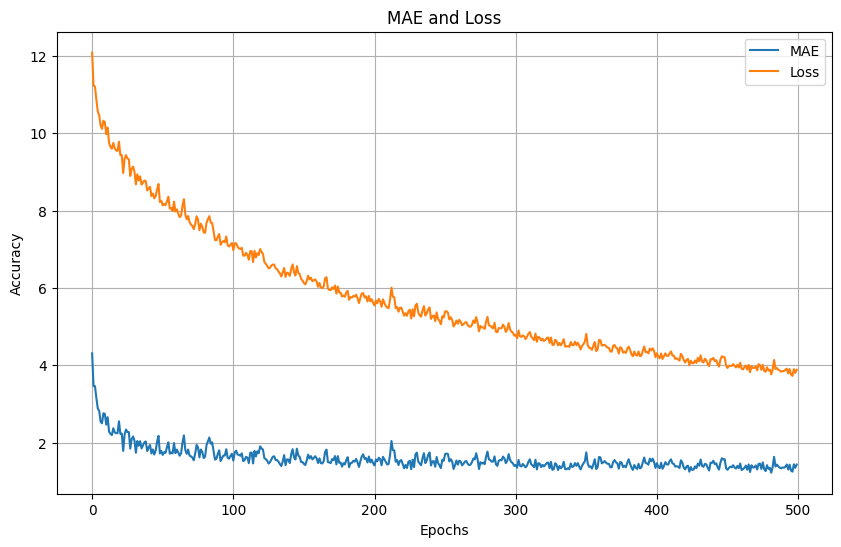

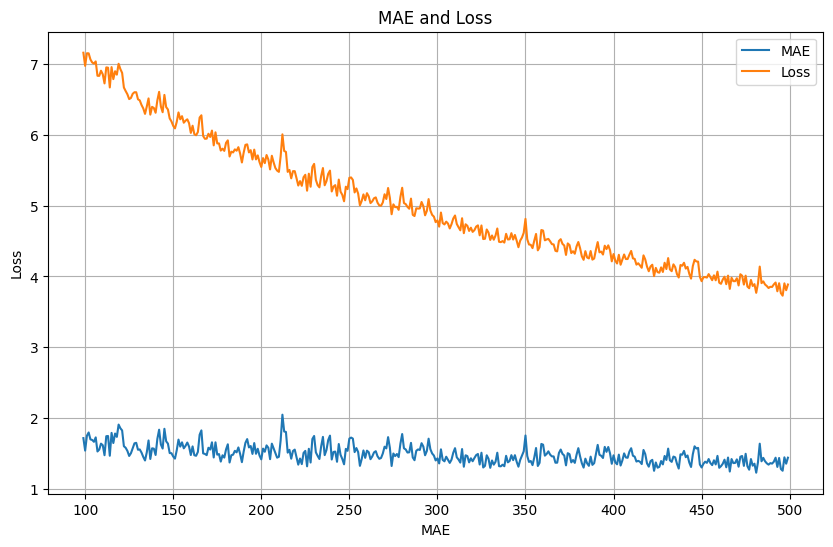

In [ ]:
# Get mae and loss from history log
mae=history.history['mae']
loss=history.history['loss']

# Get number of epochs
epochs=range(len(loss))

# Plot mae and loss
plot_series(
    x=epochs,
    y=(mae, loss),
    title='MAE and Loss',
    xlabel='Epochs',
    ylabel='Accuracy',
    legend=['MAE', 'Loss']
    )

# Only plot the last 80% of the epochs
zoom_split = int(epochs[-1] * 0.2)
epochs_zoom = epochs[zoom_split:]
mae_zoom = mae[zoom_split:]
loss_zoom = loss[zoom_split:]

# Plot zoomed mae and loss
plot_series(
    x=epochs_zoom,
    y=(mae_zoom, loss_zoom),
    title='MAE and Loss',
    xlabel='MAE',
    ylabel='Loss',
    legend=['MAE', 'Loss']
    )

## Model Prediction

As before, you can get the predictions for the validation set time range and compute the metrics.

In [ ]:
def model_forecast(model, series, window_size, batch_size):
    """Uses an input model to generate predictions on data windows

    Args:
      model (TF Keras Model) - model that accepts data windows
      series (array of float) - contains the values of the time series
      window_size (int) - the number of time steps to include in the window
      batch_size (int) - the batch size

    Returns:
      forecast (numpy array) - array containing predictions
    """

    # Generate a TF Dataset from the series values
    dataset = tf.data.Dataset.from_tensor_slices(series)

    # Window the data but only take those with the specified size
    dataset = dataset.window(window_size, shift=1, drop_remainder=True)

    # Flatten the windows by putting its elements in a single batch
    dataset = dataset.flat_map(lambda w: w.batch(window_size))

    # Create batches of windows
    dataset = dataset.batch(batch_size).prefetch(1)

    # Get predictions on the entire dataset
    forecast = model.predict(dataset)

    return forecast

4/4 [==============================] - 1s 21ms/step


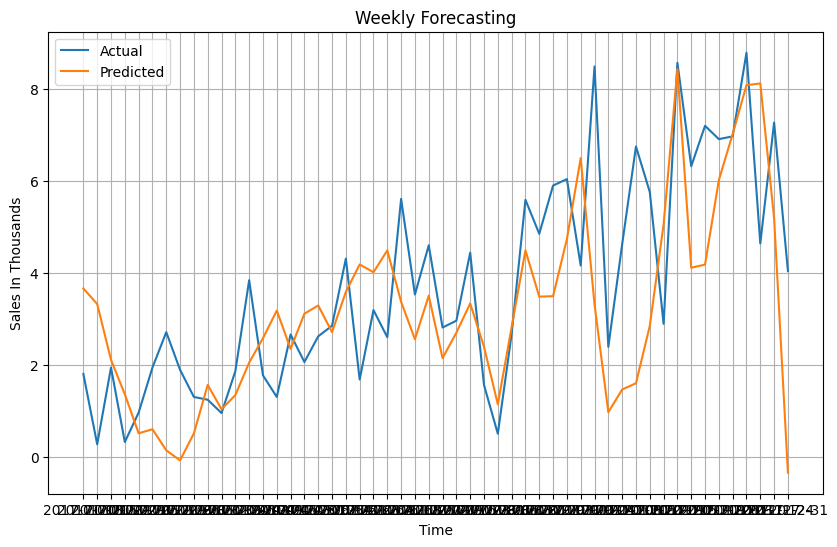

In [ ]:
# Reduce the original series
forecast_series = series[split_time-window_size:-1]

# Use helper function to generate predictions
forecast = model_forecast(model, forecast_series, window_size, batch_size)

# Drop single dimensional axis
results = forecast.squeeze()

# Plot the results
plot_series(date[split_time:], (x_valid, results), '-', 0, None, 'Weekly Forecasting', 'Time', 'Sales In Thousands', legend = ("Actual", "Predicted"))

In [ ]:
results = np.abs(results)

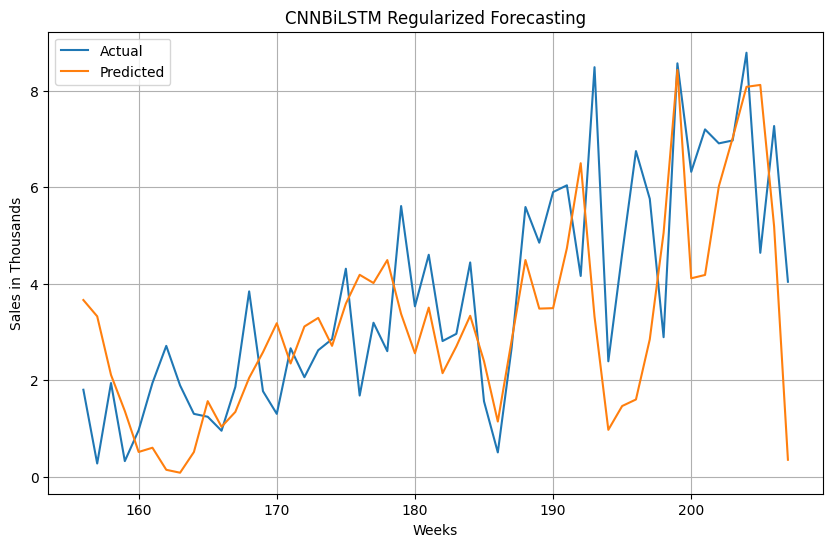

In [ ]:
plot_series(time_valid, (x_valid, results), '-', 0, None, 'CNNBiLSTM Regularized Forecasting', 'Weeks', 'Sales in Thousands', legend = ("Actual", "Predicted"))


In [ ]:
# Assuming y_true contains the true target values and y_pred contains the predicted values
def r2_score(y_true, y_pred):
    SS_res = np.sum((y_true - y_pred)**2)
    SS_tot = np.sum((y_true - np.mean(y_true))**2)
    r2 = 1 - (SS_res / SS_tot)
    return r2

In [ ]:
# Compute the MAE
print("MAE: ", tf.keras.metrics.mean_absolute_error(x_valid, results).numpy())

# Compute the mean squared error
mean_squared_error = tf.keras.metrics.mean_squared_error(x_valid, results).numpy()

# Compute the RMSE by taking the square root of the mean squared error
rmse = np.sqrt(mean_squared_error)

print("RMSE:", rmse)

r2 = r2_score(x_valid, results)
print("R2 score:", r2)

MAE:  1.5258267
RMSE: 1.9455931
R2 score: 0.26952959705319324


## Wrap Up

This concludes the final practice lab for this course! You implemented a deep and complex architecture composed of CNNs, RNNs, and DNNs. You'll be using the skills you developed throughout this course to complete the final assignment. Keep it up!

## Optional

In this optional section, you will look at another way to dynamically set the learning rate. As you may have noticed, training for a long time generates less and less changes to the loss and metrics. You can run the cell below to observe that again.

In [ ]:
# Initialize the optimizer
optimizer = tf.keras.optimizers.SGD(learning_rate=3e-7, momentum=0.9)

# Set the training parameters
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

# Train the model
history = model.fit(train_set,epochs=10)

Epoch 1/10
7/7 [==============================] - 9s 19ms/step - loss: 3.8190 - mae: 1.3472
Epoch 2/10
7/7 [==============================] - 0s 14ms/step - loss: 3.7918 - mae: 1.3346
Epoch 3/10
7/7 [==============================] - 0s 14ms/step - loss: 3.6842 - mae: 1.1863
Epoch 4/10
7/7 [==============================] - 0s 15ms/step - loss: 3.7411 - mae: 1.2843
Epoch 5/10
7/7 [==============================] - 0s 15ms/step - loss: 3.7761 - mae: 1.3044
Epoch 6/10
7/7 [==============================] - 0s 13ms/step - loss: 3.7927 - mae: 1.3208
Epoch 7/10
7/7 [==============================] - 0s 13ms/step - loss: 3.7396 - mae: 1.2736
Epoch 8/10
7/7 [==============================] - 0s 13ms/step - loss: 3.7852 - mae: 1.3249
Epoch 9/10
7/7 [==============================] - 0s 13ms/step - loss: 3.8042 - mae: 1.3532
Epoch 10/10
7/7 [==============================] - 0s 15ms/step - loss: 3.7331 - mae: 1.2456


At some point, the static learning rate you set might no longer be the optimal one when the model has been learning for some time. You may want to decrease it some more to see better improvements. One way to do that is to have your training loop gradually decay the learning rate per epoch. You can pass in a lambda function similar like the one you did for the learning rate scheduler earlier, or use [ExponentialDecay()](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/schedules/ExponentialDecay). This is a built in scheduler from the Keras API. This decays the learning rate defined by this function:

```
def decayed_learning_rate(step):
  return initial_learning_rate * decay_rate ^ (step / decay_steps)
```

See how it is used below.

In [ ]:
# Set the initial learning rate
initial_learning_rate=3e-7

# Define the scheduler
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=400,
    decay_rate=0.96,
    staircase=True)

# Set the optimizer
optimizer = tf.keras.optimizers.SGD(learning_rate=lr_schedule, momentum=0.9)

# Set the training parameters
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

# Train the model
history = model.fit(train_set,epochs=50)

Epoch 1/50
7/7 [==============================] - 6s 20ms/step - loss: 0.3931 - mae: 0.6552
Epoch 2/50
7/7 [==============================] - 0s 15ms/step - loss: 0.3622 - mae: 0.5839
Epoch 3/50
7/7 [==============================] - 0s 17ms/step - loss: 0.3781 - mae: 0.6164
Epoch 4/50
7/7 [==============================] - 0s 15ms/step - loss: 0.4162 - mae: 0.6650
Epoch 5/50
7/7 [==============================] - 0s 15ms/step - loss: 0.4283 - mae: 0.6662
Epoch 6/50
7/7 [==============================] - 0s 14ms/step - loss: 0.4247 - mae: 0.6497
Epoch 7/50
7/7 [==============================] - 0s 19ms/step - loss: 0.4342 - mae: 0.6974
Epoch 8/50
7/7 [==============================] - 0s 22ms/step - loss: 0.3726 - mae: 0.5815
Epoch 9/50
7/7 [==============================] - 0s 23ms/step - loss: 0.4323 - mae: 0.6804
Epoch 10/50
7/7 [==============================] - 0s 21ms/step - loss: 0.4125 - mae: 0.6451
Epoch 11/50
7/7 [==============================] - 0s 23ms/step - loss: 0.3961 

Now see the results by geting predicitons and computing the metrics.

4/4 [==============================] - 3s 18ms/step


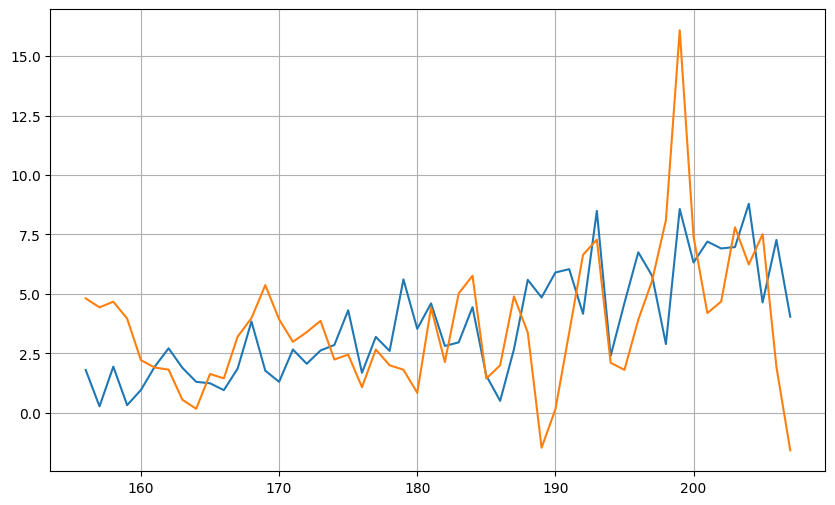

In [ ]:
# Reduce the original series
forecast_series = series[split_time-window_size:-1]

# Use helper function to generate predictions
forecast = model_forecast(model, forecast_series, window_size, batch_size)

# Drop single dimensional axis
results = forecast.squeeze()

# Plot the results
plot_series(time_valid, (x_valid, results))

In [ ]:
# Compute the MAE
tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()

2.1451762

In [ ]:
# Compute the mean squared error
mean_squared_error = tf.keras.metrics.mean_squared_error(x_valid, results).numpy()

# Compute the RMSE by taking the square root of the mean squared error
rmse = np.sqrt(mean_squared_error)

print("RMSE:", rmse)

r2 = r2_score(x_valid, results)
print("R2 score:", r2)

RMSE: 2.7788787
R2 score: -0.4901765991803362
